In [ ]:
!pip install Wand

In [ ]:
!sudo apt-get install libmagickwand-dev

In [ ]:
import os
from PIL import Image
import os.path
import time
import torch
import torchvision.datasets as dset
import torchvision.transforms as trn
import torch.utils.data as data
import numpy as np

import skimage as sk
from skimage.filters import gaussian
from io import BytesIO
from wand.image import Image as WandImage
from wand.api import library as wandlibrary
import wand.color as WandColor
import ctypes
from PIL import Image as PILImage
import cv2
from scipy.ndimage import zoom as scizoom
from scipy.ndimage.interpolation import map_coordinates
import warnings

In [ ]:
# import data path
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/'


Mounted at /content/drive


We have conducted experiments on the robustness of motion blur, color space, CAE and EDSR augmentations. This document shows the first half part of each models in the experiments -- Data Augmentation.

For each model, we have a sample part and an actual implementation part.

# CAE

## Samples

Same as EDSR, since CAE method is a complicated neural network data augmentation method, we are directly showing the images in the sample.

Reference: https://github.com/hendrycks/imagenet-r

Before CAE:


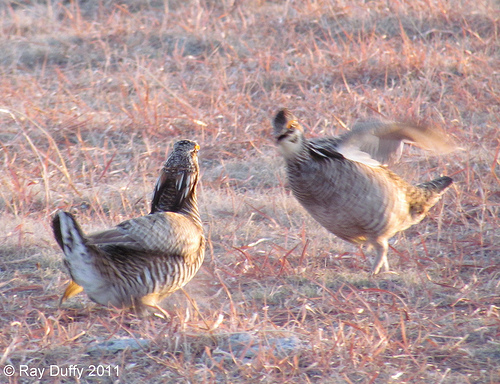

In [ ]:
print("Before CAE:")
# Read a sample image
img3 = Image.open(data_path+'pre_CAE_sample1.JPEG')
input3 = img3.convert('RGB')
img3 # Show Images

After CAE:


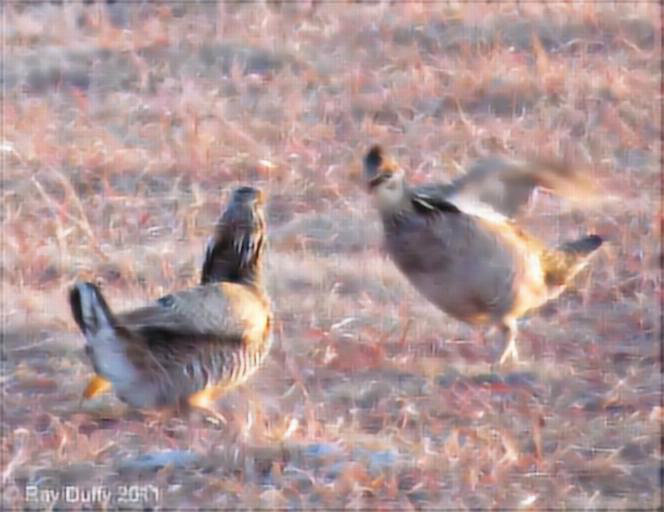

In [ ]:
print("After CAE:")
# Read a sample image
img3 = Image.open(data_path+'after_CAE_sample1.JPEG')
input3 = img3.convert('RGB')
img3 # Show Images

## Actual Data Augmentation

In [ ]:
import sys
import os
import numpy as np
import os
import shutil
import tempfile
from PIL import Image
import random
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms as trn
from torchvision import datasets
import torchvision.transforms.functional as trnF 
from torch.nn.functional import gelu, conv2d
import torch.nn.functional as F
import random
import torch.utils.data as data
from torchvision.datasets import ImageFolder
from tqdm import tqdm

from CAE_Model.cae_32x32x32_zero_pad_bin import CAE

In [ ]:
total_workers = 1
worker_number = 0

all_classes = ["n01440764", "n01443537", "n01484850", "n01491361", "n01494475", "n01496331", "n01498041", "n01514668", "n01514859", "n01518878", "n01530575", "n01531178", "n01532829", "n01534433", "n01537544", "n01558993", "n01560419", "n01580077", "n01582220", "n01592084", "n01601694", "n01608432", "n01614925", "n01616318", "n01622779", "n01629819", "n01630670", "n01631663", "n01632458", "n01632777", "n01641577", "n01644373", "n01644900", "n01664065", "n01665541", "n01667114", "n01667778", "n01669191", "n01675722", "n01677366", "n01682714", "n01685808", "n01687978", "n01688243", "n01689811", "n01692333", "n01693334", "n01694178", "n01695060", "n01697457", "n01698640", "n01704323", "n01728572", "n01728920", "n01729322", "n01729977", "n01734418", "n01735189", "n01737021", "n01739381", "n01740131", "n01742172", "n01744401", "n01748264", "n01749939", "n01751748", "n01753488", "n01755581", "n01756291", "n01768244", "n01770081", "n01770393", "n01773157", "n01773549", "n01773797", "n01774384", "n01774750", "n01775062", "n01776313", "n01784675", "n01795545", "n01796340", "n01797886", "n01798484", "n01806143", "n01806567", "n01807496", "n01817953", "n01818515", "n01819313", "n01820546", "n01824575", "n01828970", "n01829413", "n01833805", "n01843065", "n01843383", "n01847000", "n01855032", "n01855672", "n01860187", "n01871265", "n01872401", "n01873310", "n01877812", "n01882714", "n01883070", "n01910747", "n01914609", "n01917289", "n01924916", "n01930112", "n01943899", "n01944390", "n01945685", "n01950731", "n01955084", "n01968897", "n01978287", "n01978455", "n01980166", "n01981276", "n01983481", "n01984695", "n01985128", "n01986214", "n01990800", "n02002556", "n02002724", "n02006656", "n02007558", "n02009229", "n02009912", "n02011460", "n02012849", "n02013706", "n02017213", "n02018207", "n02018795", "n02025239", "n02027492", "n02028035", "n02033041", "n02037110", "n02051845", "n02056570", "n02058221", "n02066245", "n02071294", "n02074367", "n02077923", "n02085620", "n02085782", "n02085936", "n02086079", "n02086240", "n02086646", "n02086910", "n02087046", "n02087394", "n02088094", "n02088238", "n02088364", "n02088466", "n02088632", "n02089078", "n02089867", "n02089973", "n02090379", "n02090622", "n02090721", "n02091032", "n02091134", "n02091244", "n02091467", "n02091635", "n02091831", "n02092002", "n02092339", "n02093256", "n02093428", "n02093647", "n02093754", "n02093859", "n02093991", "n02094114", "n02094258", "n02094433", "n02095314", "n02095570", "n02095889", "n02096051", "n02096177", "n02096294", "n02096437", "n02096585", "n02097047", "n02097130", "n02097209", "n02097298", "n02097474", "n02097658", "n02098105", "n02098286", "n02098413", "n02099267", "n02099429", "n02099601", "n02099712", "n02099849", "n02100236", "n02100583", "n02100735", "n02100877", "n02101006", "n02101388", "n02101556", "n02102040", "n02102177", "n02102318", "n02102480", "n02102973", "n02104029", "n02104365", "n02105056", "n02105162", "n02105251", "n02105412", "n02105505", "n02105641", "n02105855", "n02106030", "n02106166", "n02106382", "n02106550", "n02106662", "n02107142", "n02107312", "n02107574", "n02107683", "n02107908", "n02108000", "n02108089", "n02108422", "n02108551", "n02108915", "n02109047", "n02109525", "n02109961", "n02110063", "n02110185", "n02110341", "n02110627", "n02110806", "n02110958", "n02111129", "n02111277", "n02111500", "n02111889", "n02112018", "n02112137", "n02112350", "n02112706", "n02113023", "n02113186", "n02113624", "n02113712", "n02113799", "n02113978", "n02114367", "n02114548", "n02114712", "n02114855", "n02115641", "n02115913", "n02116738", "n02117135", "n02119022", "n02119789", "n02120079", "n02120505", "n02123045", "n02123159", "n02123394", "n02123597", "n02124075", "n02125311", "n02127052", "n02128385", "n02128757", "n02128925", "n02129165", "n02129604", "n02130308", "n02132136", "n02133161", "n02134084", "n02134418", "n02137549", "n02138441", "n02165105", "n02165456", "n02167151", "n02168699", "n02169497", "n02172182", "n02174001", "n02177972", "n02190166", "n02206856", "n02219486", "n02226429", "n02229544", "n02231487", "n02233338", "n02236044", "n02256656", "n02259212", "n02264363", "n02268443", "n02268853", "n02276258", "n02277742", "n02279972", "n02280649", "n02281406", "n02281787", "n02317335", "n02319095", "n02321529", "n02325366", "n02326432", "n02328150", "n02342885", "n02346627", "n02356798", "n02361337", "n02363005", "n02364673", "n02389026", "n02391049", "n02395406", "n02396427", "n02397096", "n02398521", "n02403003", "n02408429", "n02410509", "n02412080", "n02415577", "n02417914", "n02422106", "n02422699", "n02423022", "n02437312", "n02437616", "n02441942", "n02442845", "n02443114", "n02443484", "n02444819", "n02445715", "n02447366", "n02454379", "n02457408", "n02480495", "n02480855", "n02481823", "n02483362", "n02483708", "n02484975", "n02486261", "n02486410", "n02487347", "n02488291", "n02488702", "n02489166", "n02490219", "n02492035", "n02492660", "n02493509", "n02493793", "n02494079", "n02497673", "n02500267", "n02504013", "n02504458", "n02509815", "n02510455", "n02514041", "n02526121", "n02536864", "n02606052", "n02607072", "n02640242", "n02641379", "n02643566", "n02655020", "n02666196", "n02667093", "n02669723", "n02672831", "n02676566", "n02687172", "n02690373", "n02692877", "n02699494", "n02701002", "n02704792", "n02708093", "n02727426", "n02730930", "n02747177", "n02749479", "n02769748", "n02776631", "n02777292", "n02782093", "n02783161", "n02786058", "n02787622", "n02788148", "n02790996", "n02791124", "n02791270", "n02793495", "n02794156", "n02795169", "n02797295", "n02799071", "n02802426", "n02804414", "n02804610", "n02807133", "n02808304", "n02808440", "n02814533", "n02814860", "n02815834", "n02817516", "n02823428", "n02823750", "n02825657", "n02834397", "n02835271", "n02837789", "n02840245", "n02841315", "n02843684", "n02859443", "n02860847", "n02865351", "n02869837", "n02870880", "n02871525", "n02877765", "n02879718", "n02883205", "n02892201", "n02892767", "n02894605", "n02895154", "n02906734", "n02909870", "n02910353", "n02916936", "n02917067", "n02927161", "n02930766", "n02939185", "n02948072", "n02950826", "n02951358", "n02951585", "n02963159", "n02965783", "n02966193", "n02966687", "n02971356", "n02974003", "n02977058", "n02978881", "n02979186", "n02980441", "n02981792", "n02988304", "n02992211", "n02992529", "n02999410", "n03000134", "n03000247", "n03000684", "n03014705", "n03016953", "n03017168", "n03018349", "n03026506", "n03028079", "n03032252", "n03041632", "n03042490", "n03045698", "n03047690", "n03062245", "n03063599", "n03063689", "n03065424", "n03075370", "n03085013", "n03089624", "n03095699", "n03100240", "n03109150", "n03110669", "n03124043", "n03124170", "n03125729", "n03126707", "n03127747", "n03127925", "n03131574", "n03133878", "n03134739", "n03141823", "n03146219", "n03160309", "n03179701", "n03180011", "n03187595", "n03188531", "n03196217", "n03197337", "n03201208", "n03207743", "n03207941", "n03208938", "n03216828", "n03218198", "n03220513", "n03223299", "n03240683", "n03249569", "n03250847", "n03255030", "n03259280", "n03271574", "n03272010", "n03272562", "n03290653", "n03291819", "n03297495", "n03314780", "n03325584", "n03337140", "n03344393", "n03345487", "n03347037", "n03355925", "n03372029", "n03376595", "n03379051", "n03384352", "n03388043", "n03388183", "n03388549", "n03393912", "n03394916", "n03400231", "n03404251", "n03417042", "n03424325", "n03425413", "n03443371", "n03444034", "n03445777", "n03445924", "n03447447", "n03447721", "n03450230", "n03452741", "n03457902", "n03459775", "n03461385", "n03467068", "n03476684", "n03476991", "n03478589", "n03481172", "n03482405", "n03483316", "n03485407", "n03485794", "n03492542", "n03494278", "n03495258", "n03496892", "n03498962", "n03527444", "n03529860", "n03530642", "n03532672", "n03534580", "n03535780", "n03538406", "n03544143", "n03584254", "n03584829", "n03590841", "n03594734", "n03594945", "n03595614", "n03598930", "n03599486", "n03602883", "n03617480", "n03623198", "n03627232", "n03630383", "n03633091", "n03637318", "n03642806", "n03649909", "n03657121", "n03658185", "n03661043", "n03662601", "n03666591", "n03670208", "n03673027", "n03676483", "n03680355", "n03690938", "n03691459", "n03692522", "n03697007", "n03706229", "n03709823", "n03710193", "n03710637", "n03710721", "n03717622", "n03720891", "n03721384", "n03724870", "n03729826", "n03733131", "n03733281", "n03733805", "n03742115", "n03743016", "n03759954", "n03761084", "n03763968", "n03764736", "n03769881", "n03770439", "n03770679", "n03773504", "n03775071", "n03775546", "n03776460", "n03777568", "n03777754", "n03781244", "n03782006", "n03785016", "n03786901", "n03787032", "n03788195", "n03788365", "n03791053", "n03792782", "n03792972", "n03793489", "n03794056", "n03796401", "n03803284", "n03804744", "n03814639", "n03814906", "n03825788", "n03832673", "n03837869", "n03838899", "n03840681", "n03841143", "n03843555", "n03854065", "n03857828", "n03866082", "n03868242", "n03868863", "n03871628", "n03873416", "n03874293", "n03874599", "n03876231", "n03877472", "n03877845", "n03884397", "n03887697", "n03888257", "n03888605", "n03891251", "n03891332", "n03895866", "n03899768", "n03902125", "n03903868", "n03908618", "n03908714", "n03916031", "n03920288", "n03924679", "n03929660", "n03929855", "n03930313", "n03930630", "n03933933", "n03935335", "n03937543", "n03938244", "n03942813", "n03944341", "n03947888", "n03950228", "n03954731", "n03956157", "n03958227", "n03961711", "n03967562", "n03970156", "n03976467", "n03976657", "n03977966", "n03980874", "n03982430", "n03983396", "n03991062", "n03992509", "n03995372", "n03998194", "n04004767", "n04005630", "n04008634", "n04009552", "n04019541", "n04023962", "n04026417", "n04033901", "n04033995", "n04037443", "n04039381", "n04040759", "n04041544", "n04044716", "n04049303", "n04065272", "n04067472", "n04069434", "n04070727", "n04074963", "n04081281", "n04086273", "n04090263", "n04099969", "n04111531", "n04116512", "n04118538", "n04118776", "n04120489", "n04125021", "n04127249", "n04131690", "n04133789", "n04136333", "n04141076", "n04141327", "n04141975", "n04146614", "n04147183", "n04149813", "n04152593", "n04153751", "n04154565", "n04162706", "n04179913", "n04192698", "n04200800", "n04201297", "n04204238", "n04204347", "n04208210", "n04209133", "n04209239", "n04228054", "n04229816", "n04235860", "n04238763", "n04239074", "n04243546", "n04251144", "n04252077", "n04252225", "n04254120", "n04254680", "n04254777", "n04258138", "n04259630", "n04263257", "n04264628", "n04265275", "n04266014", "n04270147", "n04273569", "n04275548", "n04277352", "n04285008", "n04286575", "n04296562", "n04310018", "n04311004", "n04311174", "n04317175", "n04325704", "n04326547", "n04328186", "n04330267", "n04332243", "n04335435", "n04336792", "n04344873", "n04346328", "n04347754", "n04350905", "n04355338", "n04355933", "n04356056", "n04357314", "n04366367", "n04367480", "n04370456", "n04371430", "n04371774", "n04372370", "n04376876", "n04380533", "n04389033", "n04392985", "n04398044", "n04399382", "n04404412", "n04409515", "n04417672", "n04418357", "n04423845", "n04428191", "n04429376", "n04435653", "n04442312", "n04443257", "n04447861", "n04456115", "n04458633", "n04461696", "n04462240", "n04465501", "n04467665", "n04476259", "n04479046", "n04482393", "n04483307", "n04485082", "n04486054", "n04487081", "n04487394", "n04493381", "n04501370", "n04505470", "n04507155", "n04509417", "n04515003", "n04517823", "n04522168", "n04523525", "n04525038", "n04525305", "n04532106", "n04532670", "n04536866", "n04540053", "n04542943", "n04548280", "n04548362", "n04550184", "n04552348", "n04553703", "n04554684", "n04557648", "n04560804", "n04562935", "n04579145", "n04579432", "n04584207", "n04589890", "n04590129", "n04591157", "n04591713", "n04592741", "n04596742", "n04597913", "n04599235", "n04604644", "n04606251", "n04612504", "n04613696", "n06359193", "n06596364", "n06785654", "n06794110", "n06874185", "n07248320", "n07565083", "n07579787", "n07583066", "n07584110", "n07590611", "n07613480", "n07614500", "n07615774", "n07684084", "n07693725", "n07695742", "n07697313", "n07697537", "n07711569", "n07714571", "n07714990", "n07715103", "n07716358", "n07716906", "n07717410", "n07717556", "n07718472", "n07718747", "n07720875", "n07730033", "n07734744", "n07742313", "n07745940", "n07747607", "n07749582", "n07753113", "n07753275", "n07753592", "n07754684", "n07760859", "n07768694", "n07802026", "n07831146", "n07836838", "n07860988", "n07871810", "n07873807", "n07875152", "n07880968", "n07892512", "n07920052", "n07930864", "n07932039", "n09193705", "n09229709", "n09246464", "n09256479", "n09288635", "n09332890", "n09399592", "n09421951", "n09428293", "n09468604", "n09472597", "n09835506", "n10148035", "n10565667", "n11879895", "n11939491", "n12057211", "n12144580", "n12267677", "n12620546", "n12768682", "n12985857", "n12998815", "n13037406", "n13040303", "n13044778", "n13052670", "n13054560", "n13133613", "n15075141"]
all_classes.sort()
assert len(all_classes) == 1000

# Subset for this worker
classes_chosen = np.array_split(all_classes,total_workers)[worker_number]

class ImageNetSubsetDataset(torchvision.datasets.ImageFolder):
    """
    Dataset class to take a specified subset of some larger dataset
    """
    def __init__(self, root, *args, **kwargs):
        
        print("Using {0} classes {1}".format(len(classes_chosen), classes_chosen))

        self.new_root = tempfile.mkdtemp()
        for _class in classes_chosen:
            orig_dir = os.path.join(root, _class)
            #assert os.path.isdir(orig_dir)
            
            os.symlink(orig_dir, os.path.join(self.new_root, _class))
        
        super().__init__(self.new_root, *args, **kwargs)

        return self.new_root
    
    def __del__(self):
        # Clean up
        shutil.rmtree(self.new_root)


test_transform = trn.Compose([trn.Resize(512), trn.ToTensor()])

def get_weights():
    weight_keys = ['e_conv_1.1.weight', 'e_conv_1.1.bias', 'e_conv_2.1.weight', 'e_conv_2.1.bias', 'e_block_1.1.weight', 'e_block_1.1.bias', 'e_block_1.4.weight', 'e_block_1.4.bias', 'e_block_2.1.weight', 'e_block_2.1.bias', 'e_block_2.4.weight', 'e_block_2.4.bias', 'e_block_3.1.weight', 'e_block_3.1.bias', 'e_block_3.4.weight', 'e_block_3.4.bias', 'e_conv_3.0.weight', 'e_conv_3.0.bias', 'd_up_conv_1.0.weight', 'd_up_conv_1.0.bias', 'd_up_conv_1.3.weight', 'd_up_conv_1.3.bias', 'd_block_1.1.weight', 'd_block_1.1.bias', 'd_block_1.4.weight', 'd_block_1.4.bias', 'd_block_2.1.weight', 'd_block_2.1.bias', 'd_block_2.4.weight', 'd_block_2.4.bias', 'd_block_3.1.weight', 'd_block_3.1.bias', 'd_block_3.4.weight', 'd_block_3.4.bias', 'd_up_conv_2.0.weight', 'd_up_conv_2.0.bias', 'd_up_conv_2.3.weight', 'd_up_conv_2.3.bias', 'd_up_conv_3.0.weight', 'd_up_conv_3.0.bias', 'd_up_conv_3.3.weight', 'd_up_conv_3.3.bias']
    key_mapping = dict([(str(int(i / 2)) + ".weight", key) if i % 2 == 0 else (str(int(i / 2)) + ".bias", key) for i, key in enumerate(weight_keys)])
    NUM_LAYERS = int(len(key_mapping.values()) / 2) # 21
    NUM_DISTORTIONS = 8
    MODEL_PATH = "CAE_Weights/model_final.state"
    OPTION_LAYER_MAPPING = {0: range(11, NUM_LAYERS - 5), 1: range(8, NUM_LAYERS - 7), 2: range(8, NUM_LAYERS - 7), 3: range(10, NUM_LAYERS - 7), 4: range(8, NUM_LAYERS - 7), 5: range(8, NUM_LAYERS - 7), 6: range(8, NUM_LAYERS - 7), 7: range(8, NUM_LAYERS - 7), 8: range(8, NUM_LAYERS - 7)}

    def get_name(i, tpe):
        return key_mapping[str(i) + "." + tpe]

    weights = torch.load(MODEL_PATH)
    for option in random.sample(range(NUM_DISTORTIONS), 1):
        i = np.random.choice(OPTION_LAYER_MAPPING[option])
        j = np.random.choice(OPTION_LAYER_MAPPING[option])
        weight_i = get_name(i, "weight")
        bias_i = get_name(i, "bias")
        weight_j = get_name(j, "weight")
        bias_j = get_name(j, "weight")
        if option == 0:
            weights[weight_i] = torch.flip(weights[weight_i], (0,))
            weights[bias_i] = torch.flip(weights[bias_i], (0,))
            weights[weight_j] = torch.flip(weights[weight_j], (0,))
            weights[bias_j] = torch.flip(weights[bias_j], (0,))
        elif option == 1:
            for k in [np.random.choice(weights[weight_i].size()[0]) for _ in range(12)]:
                weights[weight_i][k] = -weights[weight_i][k]
                weights[bias_i][k] = -weights[bias_i][k]
        elif option == 2:
            for k in [np.random.choice(weights[weight_i].size()[0]) for _ in range(25)]:
                weights[weight_i][k] = 0 * weights[weight_i][k]
                weights[bias_i][k] = 0 * weights[bias_i][k]
        elif option == 3:
            for k in [np.random.choice(weights[weight_i].size()[0]) for _ in range(25)]:
                weights[weight_i][k] = -gelu(weights[weight_i][k])
                weights[bias_i][k] = -gelu(weights[bias_i][k])
        elif option == 4:
            weights[weight_i] = weights[weight_i] *\
            (1 + 2 * np.float32(np.random.uniform()) * (4*torch.rand_like(weights[weight_i]-1)))
            weights[weight_j] = weights[weight_j] *\
            (1 + 2 * np.float32(np.random.uniform()) * (4*torch.rand_like(weights[weight_j]-1)))
        elif option == 5: ##### begin saurav #####
            if random.random() < 0.5:
                mask = torch.round(torch.rand_like(weights[weight_i]))
            else:
                mask = torch.round(torch.rand_like(weights[weight_i])) * 2 - 1
            weights[weight_i] *= mask
        elif option == 6:
            _k = random.randint(1, 3)
            weights[weight_i] = torch.rot90(weights[weight_i], k=_k, dims=(2,3))
        elif option == 7:
            out_filters = weights[weight_i].shape[0]
            to_zero = list(set([random.choice(list(range(out_filters))) for _ in range(out_filters // 5)]))
            weights[weight_i][to_zero] = weights[weight_i][to_zero] * -1.0
        elif option == 8:
            # Only keep the max filter value in the conv 
            c1, c2, width = weights[weight_i].shape[0], weights[weight_i].shape[1], weights[weight_i].shape[2]
            assert weights[weight_i].shape[2] == weights[weight_i].shape[3]

            w = torch.reshape(weights[weight_i], shape=(c1, c2, width ** 2))
            res = torch.topk(w, k=1)

            w_new = torch.zeros_like(w).scatter(2, res.indices, res.values)
            w_new = w_new.reshape(c1, c2, width, width)
            weights[weight_i] = w_new
        
    return weights    

net = CAE()
net.load_state_dict(get_weights())
net.cuda()
net.eval()

def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


class FolderWithPath(ImageNetSubsetDataset):
    def __init__(self, root, transform, **kwargs):
        new_root = super(FolderWithPath, self).__init__(root, transform=transform)

        classes, class_to_idx = find_classes(new_root)
        self.class_to_idx = class_to_idx
        self.idx_to_class = {v: k for k, v in class_to_idx.items()}

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.imgs[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        # /data/imagenet/ILSVRC/Data/CLS-LOC
        # /home/jtang/Desktop/CAE/
        save_path = '/data/imagenet_augment_CAE/' + self.idx_to_class[target]

        if not os.path.exists(save_path):
            os.makedirs(save_path)

        save_path += path[path.rindex('/'):]

        if np.random.uniform() < 0.05:
            weights = get_weights()
            net.load_state_dict(weights)
            net.eval()

        with torch.no_grad():
            img = trnF.to_pil_image(net(sample.unsqueeze(0).cuda()).squeeze().to('cpu').clamp(0, 1))

        img.save(save_path)

        return 0
# /data/imagenet/ILSVRC/Data/CLS-LOC
# /home/jtang/Desktop/val
distorted_dataset = FolderWithPath(
    root="/data/imagenet/ILSVRC/Data/CLS-LOC/real_train", transform=test_transform)

loader = torch.utils.data.DataLoader(distorted_dataset, batch_size=1, shuffle=True)

for _ in tqdm(loader): 
    continue

# Reference:

https://github.com/hendrycks/imagenet-r
